# [GLIDE](https://arxiv.org/abs/2112.10741)
## Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models

GLIDE(필터링됨) + 필터링된 노이즈 인식 CLIP 모델을 사용하여 텍스트 프롬프트에 따라 이미지를 생성하는 방법을 보여줍니다.



In [1]:
#@title Clone and install
%%capture
# `%%capture`는 Jupyter notebook이나 Google Colab에서 cell의 출력을 숨기는 명령어입니다.

# GLIDE (OpenAI의 Text2Image 프로젝트) 저장소를 복제(clone)합니다.
!git clone https://github.com/openai/glide-text2im.git

# 복제한 저장소의 디렉토리로 이동합니다.
%cd /content/glide-text2im/

!pip install -e .  # 현재 디렉토리의 소스 코드를 기반으로 패키지를 편집 가능 모드로 설치
!pip install ftfy  # 'ftfy'는 텍스트를 깔끔하게 정리하는 라이브러리입니다.

In [2]:
#@title Imports
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint

from glide_text2im.model_creation import (
    create_model_and_diffusion,        # 디퓨전과 함께 모델을 생성하는 함수
    model_and_diffusion_defaults,      # 모델과 디퓨전에 대한 기본 설정 제공 함수
    model_and_diffusion_defaults_upsampler,  # 업샘플러에 대한 모델과 디퓨전의 기본 설정 제공 함수
)

from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [3]:
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
device

device(type='cuda')

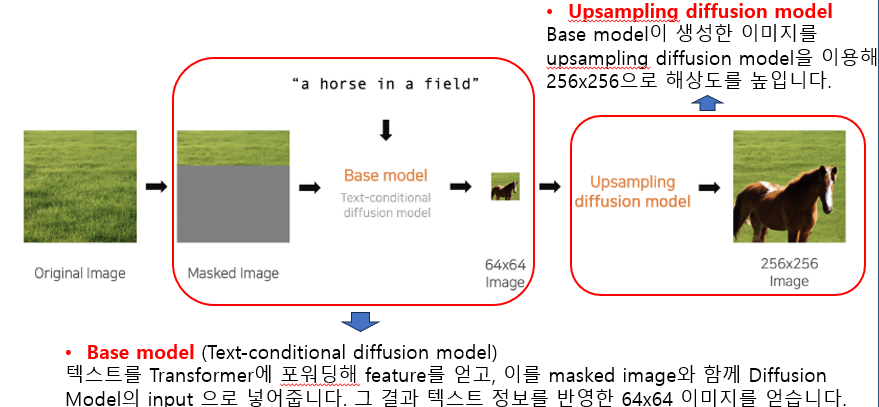

In [4]:
#@title 기본 및 업샘플러 모델 생성
# base model 생성
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda   # 16비트 부동 소수점 숫자 형식 사용
options['timestep_respacing'] = '100'   # 빠른 샘플링을 위해 100개의 확산 단계 사용
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

# upsampler model 생성
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # 매우 빠른 샘플링을 위해 27개의 확산 단계를 사용합니다.
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total base parameters 385030726
total upsampler parameters 398361286


In [5]:
#@title CLIP 모델 생성
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

<All keys matched successfully>

In [6]:
def show_images(batch: torch.Tensor):
    """ Display a batch of images inline. """
    # 이미지의 픽셀 값을 [0, 255] 범위로 조정합니다.
    # 이렇게 함으로써 이미지를 화면에 표시하기 위한 적절한 형태로 변환
    scaled = ((batch + 1)*127.5).round().clamp(0, 255).to(torch.uint8).cpu()

    # 이미지의 차원을 재정렬하여, 여러 이미지를 하나의 이미지로 연결합니다.
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])

    # Tensor를 numpy 배열로 변환하여 PIL 이미지로 만듭니다.
    img = Image.fromarray(reshaped.numpy())

    # 생성된 이미지를 저장
    img.save("/content/glide_out.png", format="png")

    # 이미지를 화면에 표시
    display(img)

In [7]:
#@title 샘플링 매개변수 설정
prompt = "A castle with advocado shape" #@param {type: "string"}
batch_size =  8 #@param {type: "number"}
guidance_scale = 3.0 #@param {type: "number"}
upsample_temp = 0.997 #@param {type: "number"}

In [8]:
#@title Image Generate
##################
# 기본 모델에서 샘플 #
##################
# 모델에 제공할 텍스트 토큰 생성
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)
print(len(tokens))
print(tokens)
print(mask)

128
[64, 16669, 351, 5271, 4533, 5485, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
[True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, 

기본 모델에서 sampling한 토큰을 생성할 image 갯수만큼 복제하여 batch로 만들어 줍니다.

In [9]:
# 입력 설정을 위한 딕셔너리 생성
model_kwargs = dict(
    # 텍스트 토큰
    tokens=torch.tensor([tokens] * batch_size, device=device),
    mask=torch.tensor([mask] * batch_size, dtype=torch.bool, device=device),
)
model_kwargs

{'tokens': tensor([[   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         ...,
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256],
         [   64, 16669,   351,  ..., 50256, 50256, 50256]], device='cuda:0'),
 'mask': tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]], device='cuda:0')}

In [10]:
# 이미지 생성 과정에서 CLIP 모델을 사용하여 생성된 이미지가
#텍스트 프롬프트와 얼마나 잘 일치하는지를 평가하고,
# 그 평가 결과를 바탕으로 이미지 생성을 가이드하는 함수(cond_fn) 설정
cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

batch로 packaging한 토큰을 이용하여 64x64 크기의 image 생성

  0%|          | 0/100 [00:00<?, ?it/s]

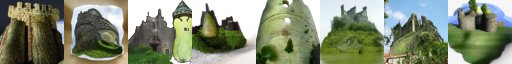

In [11]:
# 베이스 모델로부터 샘플링
model.del_cache()
samples = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
)
model.del_cache()

show_images(samples)

In [12]:
samples.shape

torch.Size([8, 3, 64, 64])

64x64 이미지를 256x256 이미지로 Upsampling

  0%|          | 0/27 [00:00<?, ?it/s]

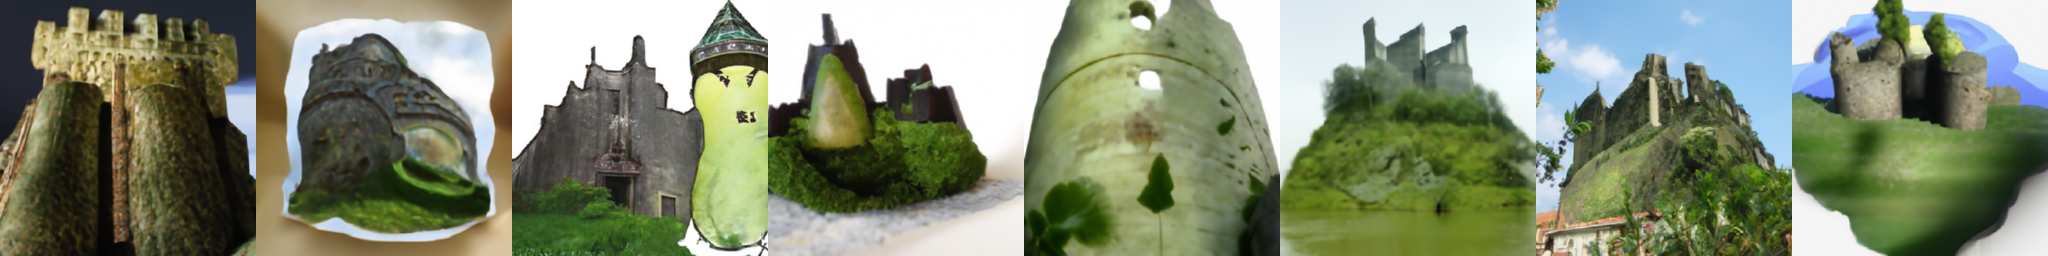

In [13]:
##########################
# 64x64 sample을 Upsampling #
##########################
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# 입력 설정을 위한 딕셔너리 생성
model_kwargs = dict(
    # 업샘플링할 저해상도 이미지
    low_res=((samples+1)*127.5).round()/127.5 - 1,    #(-1, 1) 사이의 값으로 scaling

    # 텍스트 토큰
    tokens=torch.tensor([tokens] * batch_size, device=device),
    mask=torch.tensor([mask] * batch_size,  dtype=torch.bool, device=device),
)

# 베이스 모델로부터 샘플링
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=torch.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

show_images(up_samples)

In [14]:
up_samples.shape

torch.Size([8, 3, 256, 256])

In [15]:
#@title Download (Optional)
from google.colab import files
files.download('/content/glide_out.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>